## Model Analysis Notebook

In this notebook, we train, test, and evaluate the performance of an LSTM model in wind speed prediction and compare results to the persistence method, which is a common benchmark for wind speed prediction algorithms.

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense, Dropout

In [428]:
# Define how many time steps will be used in observation and prediction
n_past = 7 # The last seven days of data
n_features = 6

# Set the universal font size for matplotlib
plt.rcParams['font.size'] = 11

In [429]:
# Define a function to split the series using a sliding window
def split_series(series, n_past=n_past):
    X, y = list(), list()
    n_past = n_past * 24
    for i in range(n_past, len(series)):
        X.append(series[range(i - n_past, i, 24), :])
        y.append(float(series[i, 2]))
    return np.array(X), np.array(y)

In [430]:
# Process and split the data for a site given its filename
def prep_data(filename, cy=2018):
    # Import the data for a single point
    data = pd.read_csv("Data\WTK_LED CONUS [2018-2020] 60min/" + filename, index_col=0)
    startyear = 2018

    # Restrict the data to the last 5 years, giving us 4 years of training and 1 year of testing data
    data = data.iloc[int(len(data)*(cy-startyear)/20):]

    # Split the data into training and testing samples
    cutoff = int(len(data)*0.8)
    test_data = data.iloc[cutoff:]
    data = data.iloc[:cutoff]
    
    # Designate which columns are used for training
    columns = [5, 6, 7, 8, 9, 10]
    
    # Normalize the testing and training data
    test_data.iloc[:, columns], test_norms = normalize(test_data.iloc[:, columns], axis=0, norm='max', return_norm=True)
    data.iloc[:, columns], train_norms = normalize(data.iloc[:, columns], axis=0, norm='max', return_norm=True)

    # Split the data into series for training
    X_train, y_train = split_series(np.array(data.iloc[:, columns]))
    X_test, y_test = split_series(np.array(test_data.iloc[:, columns]))

    # Adjust the expected output to contain only the wind speed
    # y_train, y_test = y_train[:, :, 2], y_test[:, :, 2]
    
    return X_train, y_train, X_test, y_test, train_norms, test_norms

In [431]:
# Define the model architecture
def define_model():
    # Lighter model used for additional training
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')

    return model

In [432]:
model = define_model()
model.summary()
model.input_shape

Model: "sequential_343"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_352 (LSTM)                 │ (None, 256)            │       269,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_350 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,577 (1.19 MB)

 Trainable params: 312,577 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

(None, 7, 6)

In [433]:
X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871' + '.csv', cy=2018)
model = define_model()
model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=128)

predictions = model.predict(X_test)
print(mean_absolute_error(y_test * test_norms[2], predictions * train_norms[2]))

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.3390 - val_loss: 0.1700
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1480 - val_loss: 0.1366
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1270 - val_loss: 0.1245
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1194 - val_loss: 0.1188
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1167 - val_loss: 0.1171
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1147 - val_loss: 0.1142
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1124 - val_loss: 0.1163
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1122 - val_loss: 0.1192
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1110 - val_loss: 0.1147
Epoch 10/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1105 - val_loss: 0.1110
Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1087 - val_loss: 0.1119
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Train models for every selected site
i = 1
df1 = pd.DataFrame()
df1['SiteID'], df1['MAE'] = list(), list()

for filename in os.listdir("Data/Models"):
    print(f"Training on site number {i} of 100")
    i += 1

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2018)
    model = define_model()
    model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=128)
    model.save("Data/WTK Models/" + filename)
    
    predictions = model.predict(X_test)
    df1.loc[len(df1)] = [filename[:-6], mean_absolute_error(y_test * test_norms[2], predictions * train_norms[2])]
    
df1.to_csv("Data/Raw Experiment Data/WTK Model Performance.csv")

Training on site number 1 of 100
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.3325 - val_loss: 0.1971
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1400 - val_loss: 0.1664
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1214 - val_loss: 0.1736
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1156 - val_loss: 0.1599
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1120 - val_loss: 0.1579
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1095 - val_loss: 0.1486
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1080 - val_loss: 0.1463
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1066 - val_loss: 0.1513
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1060 - val_loss: 0.1478
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1053 - val_loss: 0.1485
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1047 - val_loss: 0.1463
Epoch 12

In [ ]:
# Train one model with data starting at different years
df = pd.DataFrame()
df['Years'] = list()
df['MAE'] = list()
for year in range(2000, 2020):
    print(f"{year}")

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871.csv', cy=year)
    model = define_model()
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=128)

    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * train_norms[2])

    df.loc[len(df) + 1] = [int(year), mae]

In [ ]:
df = pd.read_csv(r'Data\Raw Experiment Data\starting year experiment.csv')
df['Years'] = [2020 - x for x in df['Years']]
# Display the data for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
plt.xlabel('Years of Data')
plt.ylabel('Mean Absolute Error (m/s)')
plt.xlim(-2, 22)
plt.scatter(df['Years'], df['MAE'], color='skyblue')
y_lim = ax.get_ylim()
plt.grid(True, axis='y', color='grey')

# Plot the polynomial line of best fit
def plot_best_fit(x, y, deg):
    coeffs = np.polyfit(x, y, deg)
    
    ylist = list()
    for n in x:
        yvalue = np.sum([coeffs[i]*n**(len(coeffs)-1-i) for i in range(len(coeffs))])
        ylist.append(yvalue)
    plt.plot(x, ylist, color='skyblue')

# plot_best_fit(df['Years'], df['MAE'], 3)

# Plot the logarithmic line of best fit
def plot_log_fit(x, y, deg):
    coeffs = np.polyfit(np.log(x), y, deg)

    ylist = list()
    for n in np.log(x):
        yvalue = np.sum([coeffs[i]*n**(len(coeffs)-1-i) for i in range(len(coeffs))])
        ylist.append(yvalue)
    plt.plot(x, ylist, color='skyblue')

plot_log_fit(df['Years'], df['MAE'], 3)

# Remove the border from the graph
for direction in ['top', 'right', 'bottom', 'left']:
    ax.spines[direction].set_visible(False)

In [ ]:
# Train one model with a varying number of epochs
df = pd.DataFrame()
df['Epochs'] = list()
df['MAE'] = list()
for epoch in range(10, 160, 10):
    print(f"{epoch}")

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871.csv')
    model = define_model()
    model.fit(X_train,y_train,epochs=epoch,validation_data=(X_test,y_test),batch_size=128)
        
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * train_norms[2])
        
    df.loc[len(df)+1] = [int(epoch), mae]

In [ ]:
df = pd.read_csv(r'Data\Raw Experiment Data\epoch experiment.csv')
# Display the data for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
plt.xlabel('Epochs Trained')
plt.ylabel('Mean Absolute Error (m/s)')
plt.ylim(y_lim)
plt.scatter(df['Epochs'], df['MAE'], color='skyblue')
plt.grid(True, axis='y', color='grey')

# Plot the line of best fit
# plot_best_fit(df['Epochs'], df['MAE'], 3)
plot_log_fit(df['Epochs'], df['MAE'], 1)

# Remove the border from the graph
for direction in ['top', 'right', 'bottom', 'left']:
    ax.spines[direction].set_visible(False)

In [ ]:
# Train models for every selected site
i = 1
for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
    print(f"Point number {i} of 100")
    i += 1

    model = define_model()
    
    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename, cy=2015)
    
    model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=128)
    model.save("Data/Models/" + filename[:-4] + ".keras")

In [ ]:
# Test models for every selected site
mae, sites = list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2015)
    model = keras.saving.load_model("Data/Models/" + filename)
    model.compile(optimizer='adam', loss='mae')
    
    predictions = model.predict(X_test)
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * train_norms[2]))
    sites.append(filename[:-6])
    print(mae[-1])
df = pd.DataFrame()
df['MAE'] = pd.Series(mae)
df['SiteID'] = pd.Series(sites)

In [ ]:
# Finally, we repeat this analysis with a persistence model that uses the wind speed from 24h before as a prediction, demonstrating the superiority of the LSTM model

mae, rmse, sites = list(), list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2015)

    predictions = [x[-1] for x in X_test[:, :, -1]]
    mae.append(mean_absolute_error(y_test * test_norms[2], np.array(predictions) * test_norms[2]))
    rmse.append(np.sqrt(mean_squared_error(y_test * test_norms[2], np.array(predictions) * test_norms[2])))
    sites.append(filename[:-6])

df1 = pd.DataFrame()
df1['MAE'] = pd.Series(mae)
df1['RMSE'] = pd.Series(rmse)
df1['SiteID'] = pd.Series(sites)

In [ ]:
# We compare the persistence model on a variety of loss metrics
print(f"Average MAE of the persistence model: {np.average(df1['MAE'])}")
print(f"Median MAE of the persistence model: {np.median(df1['MAE'])}")
print(f"Std MAE of the persistence model: {np.std(df1['MAE'])}")
print(f"Average RMSE of the persistence model: {np.average(df1['RMSE'])}")
print(f"Median RMSE of the persistence model: {np.median(df1['RMSE'])}")

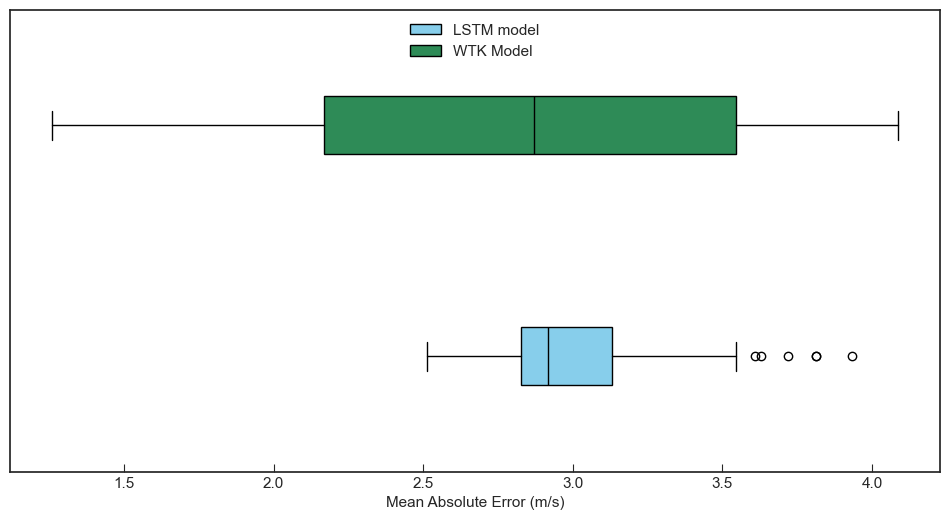

In [386]:
df = pd.read_csv(r'Data\Raw Experiment Data\Final Model Performance.csv', index_col=0)
df1 = pd.read_csv(r"Data/Raw Experiment Data/WTK Model Performance.csv", index_col=0)

# Generate a box plot to describe the MAE distribution for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
fig = plt.gcf()
frame = plt.gca()
fig.set_size_inches(12, 6)
frame.axes.get_yaxis().set_visible(False)

plt.style.use('seaborn-v0_8-ticks')
bplot = plt.boxplot([df['MAE'], df1['MAE']], vert=False, patch_artist=True, medianprops=dict(color='black'),
            boxprops=dict(facecolor='white'), widths=0.25)

for patch, color in zip(bplot['boxes'], ['skyblue', 'seagreen']):
    patch.set_facecolor(color)

plt.xlabel("Mean Absolute Error (m/s)")
plt.tick_params(axis='x', which='major', reset=True, direction='in', top=False)
ax.legend([bplot['boxes'][0], bplot['boxes'][1]], ['LSTM model', 'WTK Model'], loc='upper center')
plt.show()

In [ ]:
# We can print out some statistics of the distribution in detail
print(f"Mean: {np.average(df['MAE'])}")
print(f"Median: {np.median(df['MAE'])}")
print(f"Standard Deviation: {np.std(df['MAE'])}")
print(f"n: {len(df['MAE'])}")

print("\n")
print(f"The persistence model has a higher MAE by {(np.average(df1['MAE'])/np.average(df['MAE']) - 1) * 100}%")
print(f"Median difference: {(np.median(df1['MAE'])/np.median(df['MAE']) - 1) * 100}%")
# Unsurpisingly, the both the median and average MAE of the persistence model are around 25-30% higher than the average LSTM model MAE over all sites

In [ ]:
# Parameters we need for statistical inference
diff = pd.DataFrame()
diff['MAE'] = df1['MAE'] - df['MAE']
print('Difference statistics')
print(f"Mean: {np.average(diff['MAE'])}")
print(f"Median: {np.median(diff['MAE'])}")
print(f"Standard Deviation: {np.std(diff['MAE'])}")
print(f"n: {len(diff['MAE'])}")

In [ ]:
# To describe the differences in train time with different model parameters, we train 3 models, each encompassing the 100 selected points in the study.
df = pd.DataFrame()
df['Average MAE'] = list()
df['Median MAE'] = list()
df['Average RMSE'] = list()
df['Median RMSE'] = list()
df['Train_time'] = list()
df['Train_time std'] = list()

for pair in [[100, 2000], [100, 2015], [50, 2015]]:
    # Train models for every selected site

    mae, rmse, time_elapsed = list(), list(), list()
    i = 1
    for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
        print(f"Point number {i} of 100")
        i += 1
        
        start_time = datetime.now()
        model = define_model()
        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename, cy=pair[1])
        model.fit(X_train,y_train,epochs=pair[0],validation_data=(X_test,y_test),batch_size=128)

        predictions = model.predict(X_test)
        mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], np.array(predictions) * train_norms[2]))
        rmse.append(np.sqrt(mean_squared_error(y_test[:, 0] * test_norms[2], np.array(predictions) * train_norms[2])))
    
        time_elapsed.append((datetime.now() - start_time).total_seconds())
    df.loc[len(df)+1] = [np.average(mae), np.median(mae), np.average(rmse), np.median(rmse), np.average(time_elapsed), np.std(time_elapsed)]
df['Model'] = ['100 epochs, 20 years', '100 epochs, 5 years', '50 epochs, 5 years']

In [ ]:
df = pd.read_csv("Data/Raw Experiment Data/Train Time Experiment.csv")

# Now we can generate a figure to demonstrate the significant change in train time between the models
ax = plt.axes()
ax.set_facecolor("white")
ax.set_yticks(range(5, 40, 5))
plt.grid(True, axis='y', color='grey')
plt.bar(df['Model'], df['Train_time'], width=0.4, color="skyblue")
plt.errorbar(df['Model'], df['Train_time'], yerr=df['Train_time std'], capsize=3, linestyle="", color='deepskyblue')
plt.ylabel("Average train time (seconds)")
plt.xlabel("Network parameters")
plt.show()

In [ ]:
# We also compare the models to persistence, finding no major differences between the models in performance but significant improvements over persistence
df.loc[len(df)+1] = [np.average(df1['MAE']), np.median(df1['MAE']), np.average(df1['RMSE']), np.median(df1['RMSE']), 0, "Persistence"]
df.drop('Train_time', inplace=True, axis=1)
display(df)